- Sequence-to-sequence(Seq2seq)은 기존의 단일 RNN의 단점(긴 입력에 대한 정보 학습이 어려움)을 보완한 LSTM을 사용한 Encoder-Decoder 구조를 만들어 문맥 전체를 반영한 번역이 가능하게 함.
    - Encoder에서 Input sequence를 받으면 Representation Vector(context vector)에 정보를 담아 Decoder에게 전달해주고 Decoder는 이를 기반으로 Output sequence를 생성
    - 하지만 고정된 크기의 Representation Vector(context vector)는 정보의 손실을 야기할 수 있으며, 문장이 길어질 수록 손실이 커짐
    - 그럼, 모든 단어를 같은 비중을 주지 말고 중요한 단어에만 큰 비중을 줘서 성능을 높여보자! (**Dzmitry Bahdanau가 attention**을 제안)
    - https://eda-ai-lab.tistory.com/157
    - https://arxiv.org/abs/1409.0473
    - Bahdanau의 Attention은 t 스텝에서 Decoder의 Hidden State를 구하기 위해 T-1 스텝의 Hidden State를 사용해야 한다는 점이 있는데, 이는 재귀적으로 동작하는 RNN에 역행하는 연산으로 효율적이지 않음
    - 이를 개선한 것이 **Luong이 제안한 Attention 기법**
    - 이후 **Attention Is All You Need**라는 논문이 등장하며 RNN과 CNN을 배제하고 Attention 메커니즘에만 기반을 둔 구조인 **Transformer**가 제안됨
        - 연속성을 배제하고 Attention을 이용해서 각 단어들의 상관관계를 구하는데 집중
        - Encoder와 Decoder 방식으로 구현되어 있으며, 6개를 쌓아올려 모델을 완성함
        - Enc-Enc-...-Dec-Dec-... 구조 

## Transformer 구조
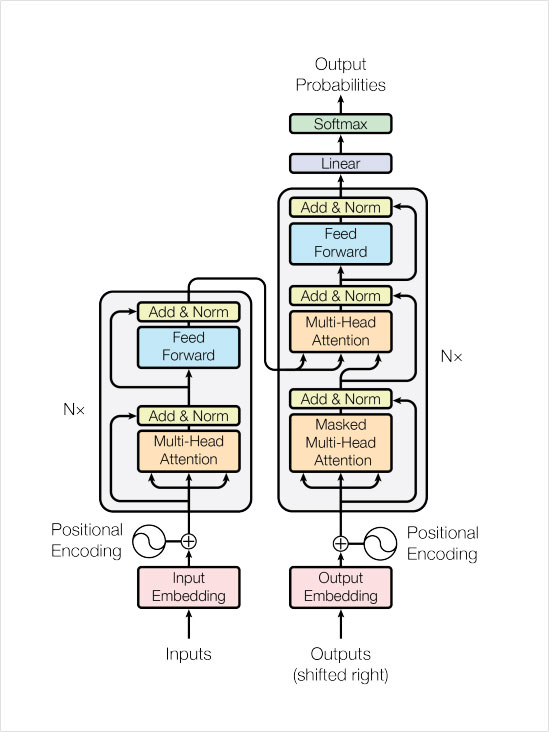
출처: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

### Positional Encoding
- 문장에 연속성을 부여하는 새로운 방법
- 입력이 들어온 단어에 단어의 위치 정보를 포함하고자 하는 것
    - d-dimensional vector로 문장의 특정 위치 정보를 표현 -> 하나의 숫자가 아님
    - Positional Encoding 수식   
    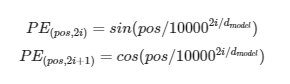  
    pos: 단어가 위치한 time-step,    i: encoding 차원의 index,     
    d model: 모델의 embedding 차원 수 - > sinusoid(사인파)embedding
    

In [3]:
import numpy as np

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

pos = 7
d_model = 4
i = 0

print("Positional Encoding 값:\n", positional_encoding(pos, d_model))

print("")
print("if pos == 0, i == 0: ", np.sin(0 / np.power(10000, 2 * i / d_model)))
print("if pos == 1, i == 0: ", np.sin(1 / np.power(10000, 2 * i / d_model)))
print("if pos == 2, i == 0: ", np.sin(2 / np.power(10000, 2 * i / d_model)))
print("if pos == 3, i == 0: ", np.sin(3 / np.power(10000, 2 * i / d_model)))

print("")
print("if pos == 0, i == 1: ", np.cos(0 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 1, i == 1: ", np.cos(1 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 2, i == 1: ", np.cos(2 / np.power(10000, 2 * i + 1 / d_model)))
print("if pos == 3, i == 1: ", np.cos(3 / np.power(10000, 2 * i + 1 / d_model)))

Positional Encoding 값:
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]
 [-0.95892427  0.87758256  0.04997917  0.9999875 ]
 [-0.2794155   0.82533561  0.05996401  0.999982  ]]

if pos == 0, i == 0:  0.0
if pos == 1, i == 0:  0.8414709848078965
if pos == 2, i == 0:  0.9092974268256817
if pos == 3, i == 0:  0.1411200080598672

if pos == 0, i == 1:  1.0
if pos == 1, i == 1:  0.9950041652780258
if pos == 2, i == 1:  0.9800665778412416
if pos == 3, i == 1:  0.955336489125606


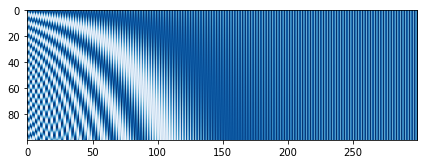

In [4]:
import matplotlib.pyplot as plt

# 세로축이 Time-step에 해당하고 가로축이 Word Embedding에 더해질 Position 값
plt.figure(figsize=(7, 7))
plt.imshow(positional_encoding(100, 300), cmap='Blues')
plt.show()

### Multi-Head Attention
- Positional Embedding이 된 문장으로부터 Attention을 추출하는 부분
- Masked Multi-Head Attention 부분은 Multi-Head Attention에 비해  인과 관계 마스킹(Causality Masking) 과정이 추가됨
- Multi-Head Attention은 Linear 레이어와 Scaled Dot-Product Attention 레이어로 이루어짐
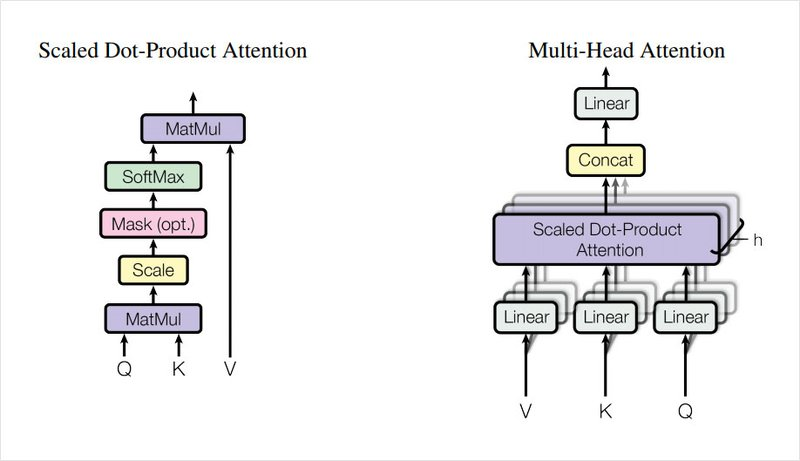

#### Scaled Dot-Product Attention
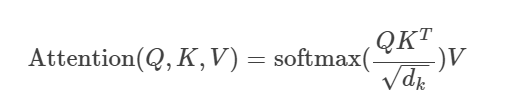
- Query와 Key를 Dot-product를 한 후 Softmax를 취하는 이유: 하나의 Query와 모든 Key들 사이의 연관성(유사도)을 계산한 후 그 값을 확률 값으로 만든다. 이는 Query가 어떤 Key와 높은 확률로 연관이 있는 지 계산한다.
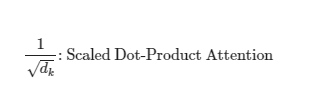
- Attention 값을 나눠준다는 것에서 "Scaled" Dot-Product Attention이라고 불립니다. 이 Scale 과정이 필요한 이유: Embedding 차원 수가 깊어지면 깊어질수록 Dot-Product의 값은 커지게 되어 Softmax를 거치고 나면 미분 값이 작아지는 현상이 나타나 학습이 느려지거나 잘 안될 수 있다. 그 경우를 대비해 Scale을 적용한다.
- Scaled Dot-Product Attention은 Additive(합 연산 기반) Attention 과 Dot-Product(=Multiplicative, 곱 연산 기반) Attention 중 후자를 사용한 Attention.
- 차원 수가 깊어짐에 따라 Softmax 값이 작아지는 것을 방지하기 위해 Scale 과정을 포함
- 이 과정이 포함되어 Scaled Dot-Product Attention이라고 불림
[참고](https://reniew.github.io/43/)

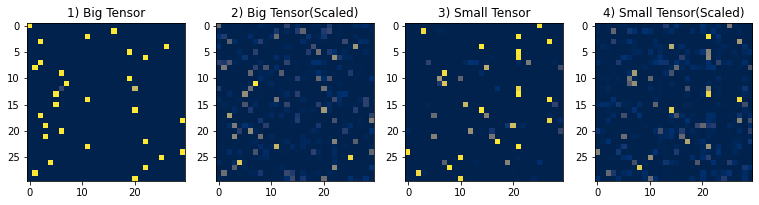

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

length = 30
big_dim = 1024.
small_dim = 10.

big_tensor = make_dot_product_tensor((length, int(big_dim)))
scaled_big_tensor = big_tensor / tf.sqrt(big_dim)
small_tensor = make_dot_product_tensor((length, int(small_dim)))
scaled_small_tensor = small_tensor / tf.sqrt(small_dim)

fig = plt.figure(figsize=(13, 6))

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.set_title('1) Big Tensor')
ax2.set_title('2) Big Tensor(Scaled)')
ax3.set_title('3) Small Tensor')
ax4.set_title('4) Small Tensor(Scaled)')

ax1.imshow(tf.nn.softmax(big_tensor, axis=-1).numpy(), cmap='cividis')
ax2.imshow(tf.nn.softmax(scaled_big_tensor, axis=-1).numpy(), cmap='cividis')
ax3.imshow(tf.nn.softmax(small_tensor, axis=-1).numpy(), cmap='cividis')
ax4.imshow(tf.nn.softmax(scaled_small_tensor, axis=-1).numpy(), cmap='cividis')

plt.show()

- 모두 같은 범위인 [-3, 3]에서 랜덤 Tensor를 만들어 실제 Attention을 하듯 Dot-Product를 하고, Softmax를 취함
- 어두운 부분으로는 미분값인 Gradinet가 흐르기 어렵기 때문에 모델이 넓은 특성을 학습하기 어려움 -> 히트맵이 선명할 수록 모델의 학습이 편협해짐

### 인과 관계 마스킹(Causality Masking)
- Seq2seq에서 Decoder에는 자기 자신을 입력으로 하여 자기 자신을 포함하여 자기 자신을 예측하는 자기 회귀(Autoregressiove)를 가짐
- 하지만 트랜스포머는 모든 단어를 병렬적으로 처리하기 때문에 자기 회귀 특성을 잃게 됨. 
- 이러한 자기 회귀적인 특성을 살리기 위해 저자들은 **인과관계마스킹**을 추가함
- 인과관계마스킹은 목표하는 문장의 일부를 가려 인위적으로 연속성을 학습하게 하는 방법임
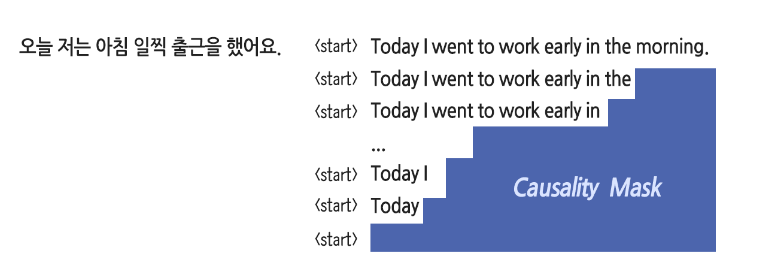
- 테스트 시 소스 문장을 Encoder에 전달하고 타겟 문장은 \<start>만 넣더라도 모델이 \<start> 토큰만 보고 문장을 생성한 적(위 그림의 마지막 Step)이 있기 때문에 첫 번째 단어를 생성해낼 수 있음
- 생성된 단어는 다시 입력으로 전달되어 자기 회귀적 문장을 생성
- 이러한 이유로 인과관계 마스크는 대각항을 포함하지 않는 삼각 행렬의 모양새를 가짐


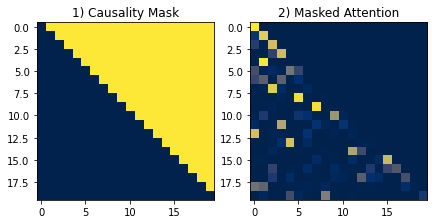

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3), [1, 0])

    return tf.tensordot(A, B, axes=1)

def generate_causality_mask(seq_len):
    mask = 1 - np.cumsum(np.eye(seq_len, seq_len), 0)
    return mask

sample_tensor = make_dot_product_tensor((20, 512))
sample_tensor = sample_tensor / tf.sqrt(512.)

mask = generate_causality_mask(sample_tensor.shape[0])

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('1) Causality Mask')
ax2.set_title('2) Masked Attention')

ax1.imshow((tf.ones(sample_tensor.shape) + mask).numpy(), cmap='cividis')

mask *= -1e9
ax2.imshow(tf.nn.softmax(sample_tensor + mask, axis=-1).numpy(), cmap='cividis')

plt.show()

- 좌측은 실제 마스크의 형태, 우측은 마스킹이 적용된 Attention
- 마스킹은 마스킹 할 영역을 -∞로 채우고 그 외 영역을 0으로 채운 배열을 Dot-Product된 값에 더해주는 방식으로 진행
- 후에 진행될 Softmax는 큰 값에 높은 확률을 할당하는 함수이므로 -∞로 가득 찬 마스킹 영역에는 무조건 0의 확률을 할당

### Multi-Head Attention
- 예를 들어, 바나나라는 단어가 512차원의 embedding을 가지고 있다고 가정할때, 이중 64는 노란색에 관한, 나머지 64는 맛에 대한 정보를 표현한다고 할때, 이를 한번에 처리하는 것보다 여러 개의 Head로 나눠서 처리하면 Embedding의 다양한 정보를 캐치할 수 있지 않을까라는 아이디어에서 제안됨
- Head는 주로 8개를 사용
-  Embedding된 10개 단어의 문장이 [10, 512]의 형태를 가진다면, Multi-Head Attention은 이를 [10, 8, 64]로 분할하여 연산합니다. 각 64차원의 Embedding을 독립적으로 Attention한 후, 이를 이어붙여 다시금 [10, 512]의 형태로 되돌리며 연산은 끝이 남
- Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 앞단에 Linear 레이어를 추가 
- Linear 레이어는 데이터를 특정 분포로 매핑 시키는 역할을 해줌
- Linear 레이어는 Multi-Head Attention이 잘 동작할 수 있는 적합한 공간으로 Embedding을 매핑해줌
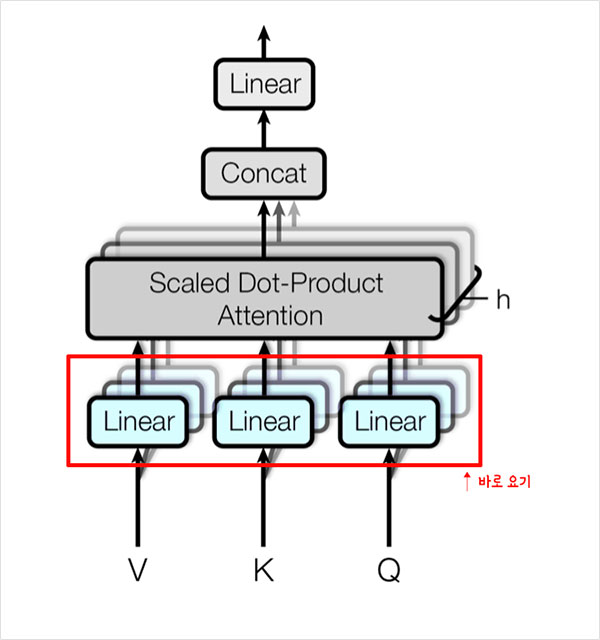
-  각각의 Head가 Attention 한 값이 균일한 분포를 가질 거란 보장이 없습니다. 따라서 모든 Attention 값을 합쳐준 후, 최종적으로 Linear 레이어를 거치며 비로소 Multi-Head Attention이 마무리가 됨

### Position-wise Feed-Forward Networks

### Additional Techniques
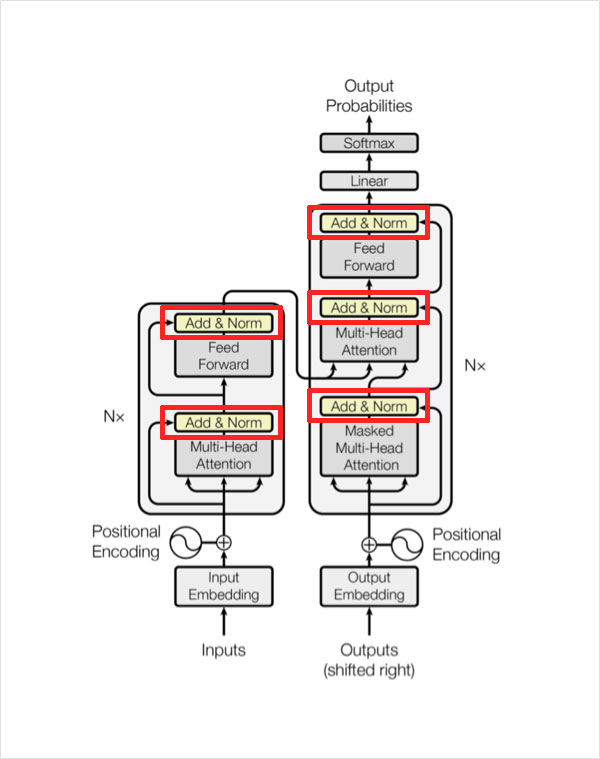
#### Layer Normalization
- [10, 512]에서 512차원 Feature를 정규화하여 분포를 일정하게 맞춰주는 것
- [Introduction to Deep Learning Normalization](https://subinium.github.io/introduction-to-normalization/)
#### Residual Connection
- Skip Connection이라고도 불림
- ResNet에서 등장 : y = f(x) + x
#### Learning Rate Schedular
- 트랜스포머는 Adam Optimizer를 사용했는데, Learning Rate를 수식에 따라 변화시키며 사용했다는 특이점이 있음
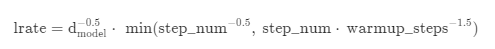
- warmup_step까지는 lrate가 선형적으로 증가하고 이후 step_num에 비례해 점차 감소하는 모양새를 보임

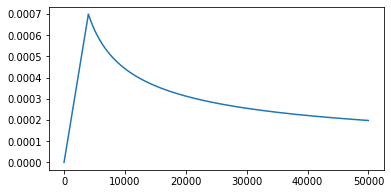

In [7]:
import matplotlib.pyplot as plt
import numpy as np

d_model = 512
warmup_steps = 4000

lrates = []
for step_num in range(1, 50000):
    lrate = (np.power(d_model, -0.5)) * np.min(
        [np.power(step_num, -0.5), step_num * np.power(warmup_steps, -1.5)])
    lrates.append(lrate)

plt.figure(figsize=(6, 3))
plt.plot(lrates)
plt.show()

-  초반 학습이 잘되지 않은 상태에서의 학습 효율이 늘어나고, 어느 정도 학습이 된 후반에는 디테일한 튜닝을 통해 Global Minimum을 찾아가는 효과가 나게 됨
- 학습의 초반과 후반은 warmup_steps 값에 따라 결정

#### Weight Sharing
- 모델의 일부 레이어가 동일한 사이즈의 Weight를 가질 때 종종 등장하는 테크닉
- 하나의 Weight를 두 개 이상의 레이어가 동시에 사용하도록 하는 것
-  많은 Weight가 곧 성능으로 이어지지 않고, 외려 Optimization에서 불리한 경향을 보인다는 것을 생각하면 이해하기 쉬움
-  Weight Sharing은 튜닝해야 할 파라미터 수가 감소하기 때문에 학습에 더 유리하며 자체적으로 Regularization 되는 효과도 있음 -> 과적합 피하기 좋음
- 트랜스포머에서는 Decoder의 Embedding 레이어와 출력층 Linear 레이어의 Weight를 공유하는 방식을 사용

### 트랜스포머, 그 후엔
- GPT와 BERT의 등장
    - GPT는 단방향 Attention을 사용하지만 BERT는 양방향 Attetion을 사용한다.
    - GPT는 트랜스포머에서 디코더(decoder)만 사용하고 BERT는 인코더(encoder)만 사용한다.
    - GPT는 문장을 생성할 수 있지만 BERT는 문장의 의미를 추출하는 데 강점을 가지고 있다.
- Transformer-XL : 보다 긴 입력 길이를 처리하도록 기존의 트랜스포머에 Recurrence라는 개념을 추가
- Reformer : 연산량 측면에서 혁신적으로 개선한 모델
- 이후, Multi-Head의 개수 관련 등 여러 연구가 진행됨